In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset EDA

In [2]:
df = pd.read_csv('data.csv')
df1 = pd.read_csv('synthetic.csv')
df2 = pd.read_csv('synthetic1.csv')
df3 = pd.read_csv('synthetic2.csv')

In [3]:
frames = [df, df1, df2, df3]
df = pd.concat(frames) 
df

,Age,Gender,Ethnicity,Region,Socioeconomic Status,Symptom Description,Symptom Severity,Duration of Symptoms (days),Additional Symptoms,Chronic Condition,Allergies,Previous Visits,Potential Condition,Suggested Action,Insurance Status
0,30.0,Female,Other,Suburban,High,chest pain,7.0,23.0,fever,NaN,NaN,NaN,Anxiety,Visit Doctor,No
1,63.0,Male,Caucasian,Urban,Middle,mild headache,1.0,5.0,nausea,NaN,Dust,4.0,Diabetes,Take Home Care Measures,Yes
2,70.0,Other,Other,Urban,High,NaN,NaN,19.0,fatigue,NaN,Peanuts,6.0,Flu,Take Home Care Measures,No
3,32.0,Male,NaN,NaN,High,fever and body aches,2.0,1.0,fever,NaN,NaN,7.0,Common Cold,Visit Doctor,No
4,NaN,Other,African American,Rural,Middle,fatigue and weakness,4.0,7.0,muscle aches,NaN,Penicillin,8.0,Arthritis,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,26.0,Female,Caucasian,Rural,Low,muscle aches,7.0,29.0,cough,Diabetes,Peanuts,2.0,Arthritis,Visit Doctor,No
996,47.0,Other,Other,Urban,Middle,back pain,3.0,13.0,nausea,NaN,Pollen,0.0,Sciatica,Take Home Care Measures,Yes
997,68.0,Other,African American,Suburban,Middle,"back pain, fatigue and weakness, dizziness",7.0,7.0,NaN,NaN,Dust,5.0,Sciatica,Visit Doctor,Yes
998,26.0,Male,African American,Suburban,Low,"mild headache, muscle aches",1.0,8.0,fever,Diabetes,Dust,9.0,Migraine,Take Home Care Measures,Yes


In [4]:
df.describe()

,Age,Symptom Severity,Duration of Symptoms (days),Previous Visits
count,3410.000000,3389.000000,3398.000000,3401.000000
mean,50.792962,5.433756,15.672749,4.989415
std,19.759465,2.876870,8.659355,3.144819
min,18.000000,1.000000,1.000000,0.000000
25%,34.000000,3.000000,8.000000,2.000000
50%,51.000000,5.000000,16.000000,5.000000
75%,68.000000,8.000000,23.000000,8.000000
max,90.000000,10.000000,30.000000,10.000000


In [5]:
df.isnull().sum()

Age                             190
Gender                          221
Ethnicity                       194
Region                          203
Socioeconomic Status            205
Symptom Description             205
Symptom Severity                211
Duration of Symptoms (days)     202
Additional Symptoms             626
Chronic Condition              1091
Allergies                       921
Previous Visits                 199
Potential Condition             192
Suggested Action                226
Insurance Status                202
dtype: int64

In [ ]:
# Fill missing values for categorical columns with 'Unknown' or relevant placeholders
df['Ethnicity'].fillna('Unknown', inplace=True)
df['Region'].fillna('Unknown', inplace=True)
df['Chronic Condition'].fillna('None', inplace=True)
df['Potential Condition'].fillna('None', inplace=True)
df['Additional Symptoms'].fillna('None', inplace=True)
df['Allergies'].fillna('None', inplace=True)
df['Insurance Status'].fillna('Unknown', inplace=True)

/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/2742166147.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Ethnicity'].fillna('Unknown', inplace=True)
/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/2742166147.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

In [7]:
# For numerical columns, fill missing values with median values as these represent patient demographics or symptom data
#df['Age'].fillna(df['Age'].median(), inplace=True)
df['Symptom Severity'].fillna(df['Symptom Severity'].median(), inplace=True)
df['Duration of Symptoms (days)'].fillna(df['Duration of Symptoms (days)'].median(), inplace=True)
df['Previous Visits'].fillna(df['Previous Visits'].median(), inplace=True)

/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/3350521121.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Symptom Severity'].fillna(df['Symptom Severity'].median(), inplace=True)
/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/3350521121.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whic

In [8]:
# For gender and socioeconomic status that cannot be generated
# since there are no reported symptoms description for omce with nan values, they also will be dropped
df = df.dropna()

In [9]:
df.isnull().sum()

Age                            0
Gender                         0
Ethnicity                      0
Region                         0
Socioeconomic Status           0
Symptom Description            0
Symptom Severity               0
Duration of Symptoms (days)    0
Additional Symptoms            0
Chronic Condition              0
Allergies                      0
Previous Visits                0
Potential Condition            0
Suggested Action               0
Insurance Status               0
dtype: int64

In [10]:
df.duplicated()

0      False
1      False
3      False
8      False
10     False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 2798, dtype: bool

In [11]:
# Standardize text formatting in 'Symptom Description' and 'Potential Condition'
df['Symptom Description'] = df['Symptom Description'].str.lower().str.strip()
df['Potential Condition'] = df['Potential Condition'].str.title().str.strip()

/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/843564582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Symptom Description'] = df['Symptom Description'].str.lower().str.strip()
/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/843564582.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Potential Condition'] = df['Potential Condition'].str.title().str.strip()


In [12]:
df

,Age,Gender,Ethnicity,Region,Socioeconomic Status,Symptom Description,Symptom Severity,Duration of Symptoms (days),Additional Symptoms,Chronic Condition,Allergies,Previous Visits,Potential Condition,Suggested Action,Insurance Status
0,30.0,Female,Other,Suburban,High,chest pain,7.0,23.0,fever,None,None,5.0,Anxiety,Visit Doctor,No
1,63.0,Male,Caucasian,Urban,Middle,mild headache,1.0,5.0,nausea,None,Dust,4.0,Diabetes,Take Home Care Measures,Yes
3,32.0,Male,Unknown,Unknown,High,fever and body aches,2.0,1.0,fever,None,None,7.0,Common Cold,Visit Doctor,No
8,22.0,Other,Other,Urban,High,blurry vision,4.0,11.0,fever,Diabetes,None,5.0,Common Cold,Visit Doctor,No
10,84.0,Male,Hispanic,Unknown,Low,sharp stomach pain,10.0,14.0,None,Diabetes,None,6.0,Hypertension,Take Home Care Measures,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,26.0,Female,Caucasian,Rural,Low,muscle aches,7.0,29.0,cough,Diabetes,Peanuts,2.0,Arthritis,Visit Doctor,No
996,47.0,Other,Other,Urban,Middle,back pain,3.0,13.0,nausea,None,Pollen,0.0,Sciatica,Take Home Care Measures,Yes
997,68.0,Other,African American,Suburban,Middle,"back pain, fatigue and weakness, dizziness",7.0,7.0,None,None,Dust,5.0,Sciatica,Visit Doctor,Yes
998,26.0,Male,African American,Suburban,Low,"mild headache, muscle aches",1.0,8.0,fever,Diabetes,Dust,9.0,Migraine,Take Home Care Measures,Yes


## Data Visualisation

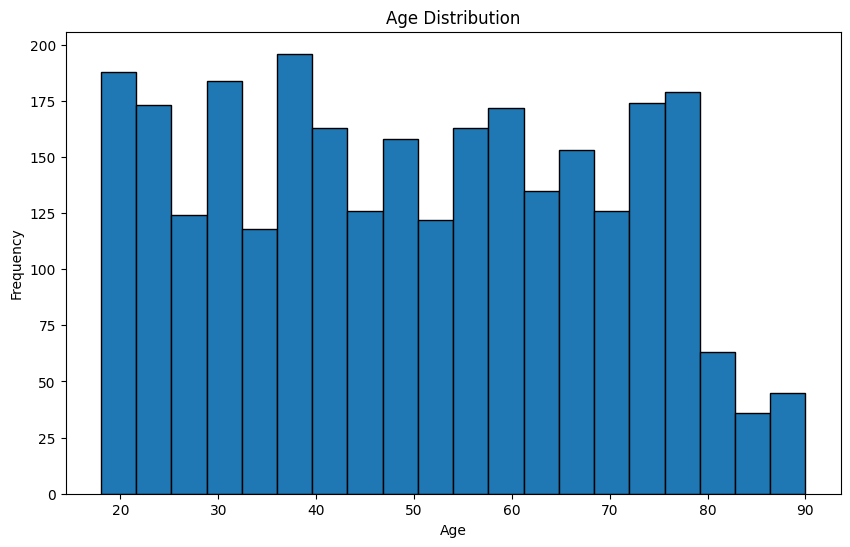

In [13]:
# Age Disttibution
plt.figure(figsize=(10, 6))
df['Age'].dropna().plot(kind='hist', bins=20, edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

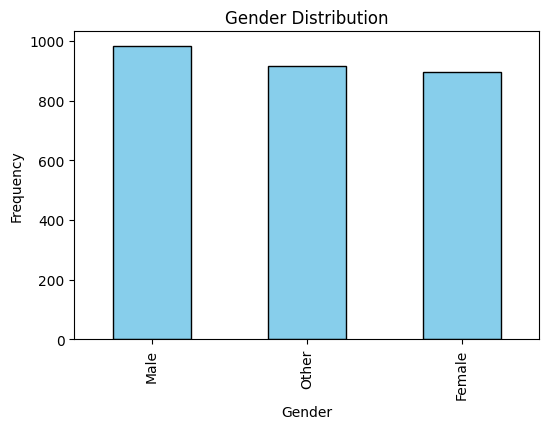

In [14]:
# Gender Distribution
plt.figure(figsize=(6, 4))
df['Gender'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.show()

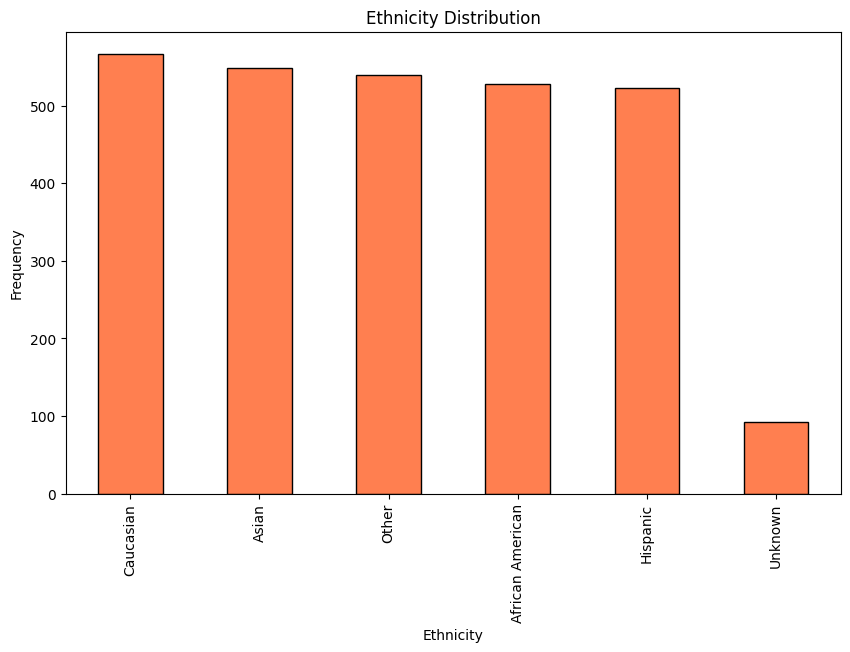

In [15]:
# Ethnicity Distibution
plt.figure(figsize=(10, 6))
df['Ethnicity'].value_counts().plot(kind='bar', color='coral', edgecolor='black')
plt.title("Ethnicity Distribution")
plt.xlabel("Ethnicity")
plt.ylabel("Frequency")
plt.show()

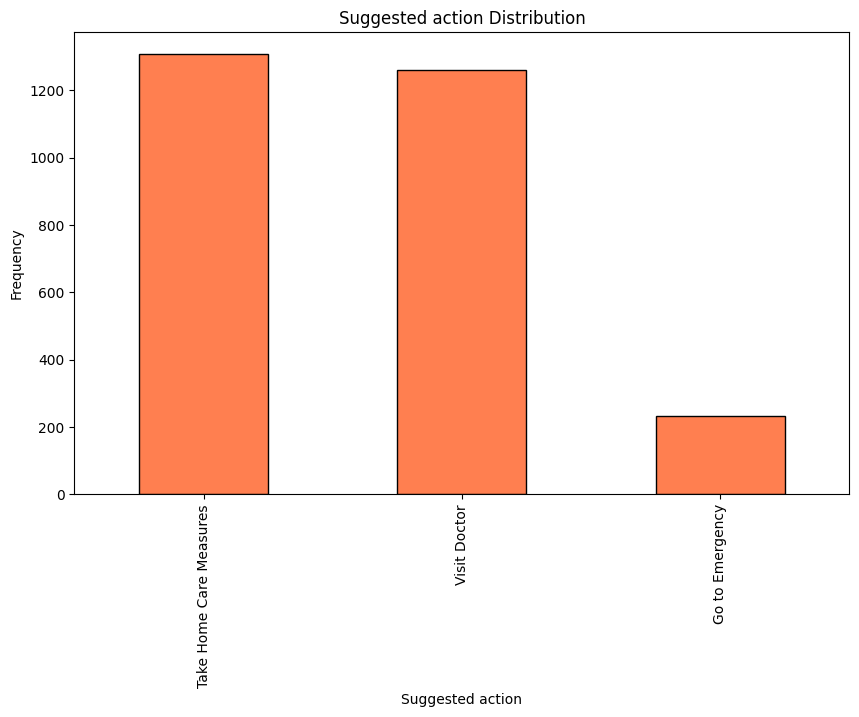

In [16]:
# Suggested action Distibution
plt.figure(figsize=(10, 6))
df['Suggested Action'].value_counts().plot(kind='bar', color='coral', edgecolor='black')
plt.title("Suggested action Distribution")
plt.xlabel("Suggested action")
plt.ylabel("Frequency")
plt.show()

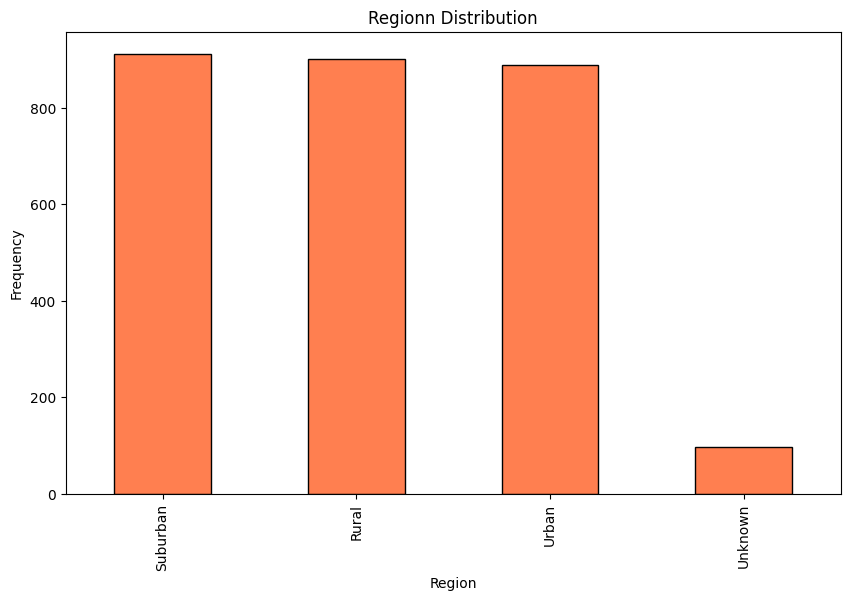

In [17]:
# Region Distibution
plt.figure(figsize=(10, 6))
df['Region'].value_counts().plot(kind='bar', color='coral', edgecolor='black')
plt.title("Regionn Distribution")
plt.xlabel("Region")
plt.ylabel("Frequency")
plt.show()

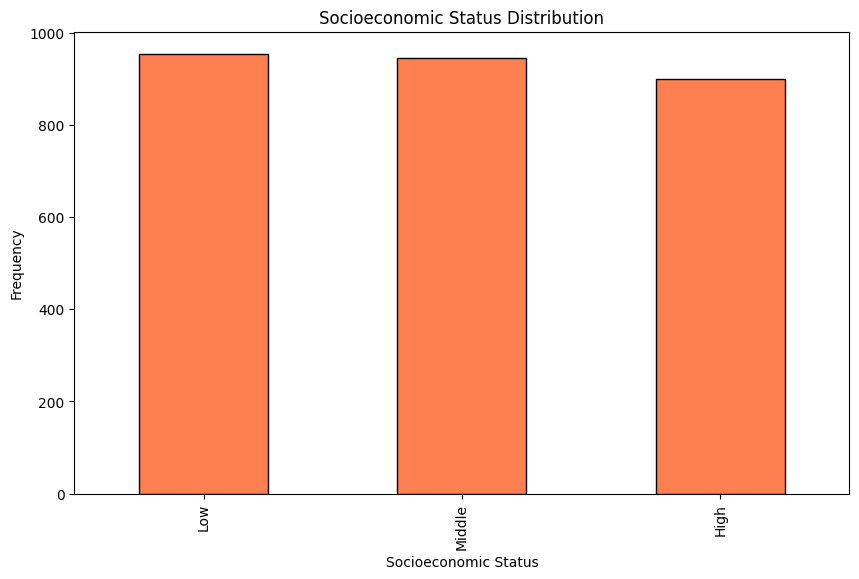

In [18]:
# Socioeconomic Status Distibution
plt.figure(figsize=(10, 6))
df['Socioeconomic Status'].value_counts().plot(kind='bar', color='coral', edgecolor='black')
plt.title("Socioeconomic Status Distribution")
plt.xlabel("Socioeconomic Status")
plt.ylabel("Frequency")
plt.show()

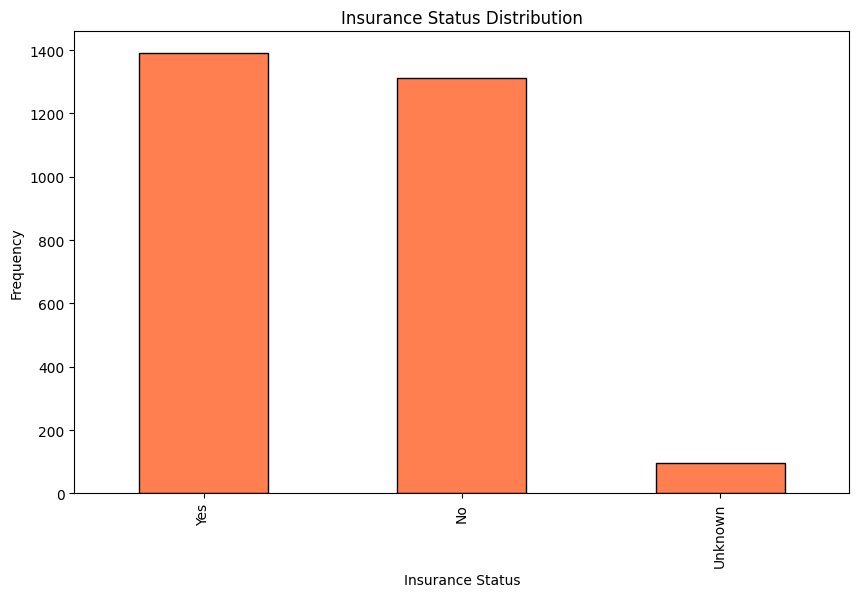

In [19]:
# Insurance Status Distibution
plt.figure(figsize=(10, 6))
df['Insurance Status'].value_counts().plot(kind='bar', color='coral', edgecolor='black')
plt.title("Insurance Status Distribution")
plt.xlabel("Insurance Status")
plt.ylabel("Frequency")
plt.show()

In [20]:
# Cross-tabulate Gender and Symptom Type
cross_tab = pd.crosstab(df['Gender'], df['Symptom Description'])
cross_tab

Symptom Description,back pain,back pain and muscle stiffness,"back pain, chest pain","back pain, chest pain, dizziness","back pain, chest pain, fever and body aches","back pain, chest pain, mild headache","back pain, chest pain, nausea","back pain, chest pain, shortness of breath","back pain, chest pain, sore throat","back pain, dizziness",...,"sore throat, muscle aches, fever and body aches","sore throat, muscle aches, shortness of breath","sore throat, nausea","sore throat, nausea, fatigue and weakness","sore throat, nausea, muscle aches","sore throat, shortness of breath","sore throat, shortness of breath, back pain","sore throat, shortness of breath, chest pain","sore throat, shortness of breath, mild headache","sore throat, shortness of breath, muscle aches"
Gender,,,,,,,,,,,,,,,,,,,,,
Female,19,13,3,0,0,0,1,3,0,0,...,1,0,2,1,0,4,0,0,1,1
Male,27,11,3,0,1,1,2,1,1,3,...,0,0,1,1,2,3,0,0,0,0
Other,32,10,6,1,0,1,0,0,0,2,...,0,1,5,1,0,2,1,1,0,0


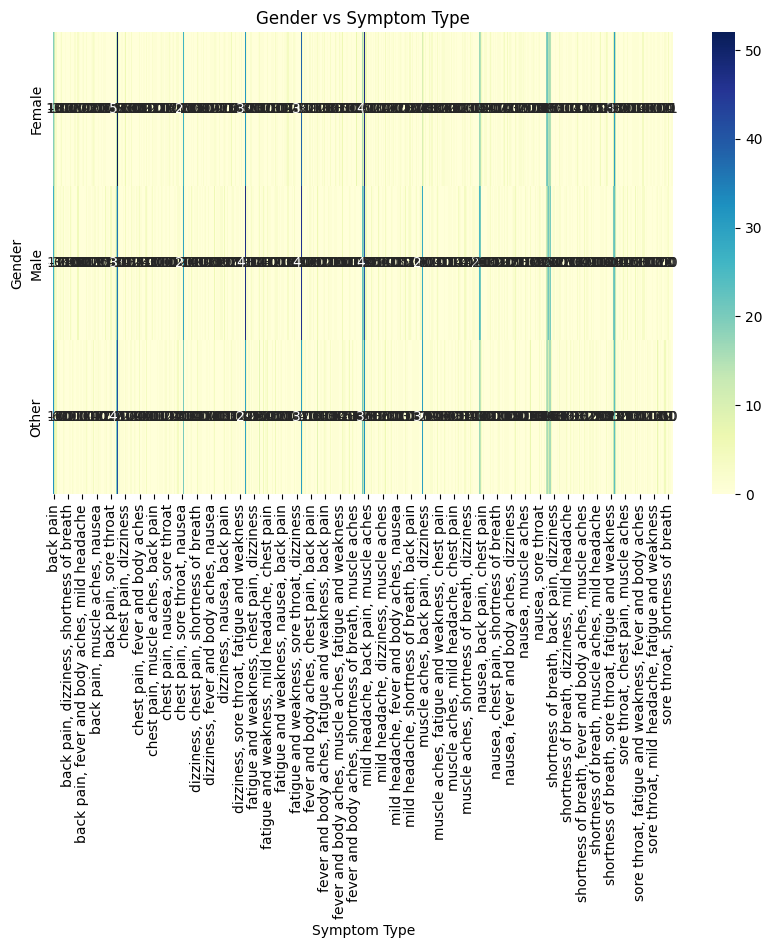

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Gender vs Symptom Type")
plt.xlabel("Symptom Type")
plt.ylabel("Gender")
plt.show()

## Implement NLP model (BERT)

In [22]:
# Encode categorical variables
label_encoders = {}
categories = ['Gender', 'Ethnicity', 'Region', 'Socioeconomic Status', 'Insurance Status', 'Chronic Condition', 'Allergies']
for column in categories:
    label_encoders[column] = LabelEncoder()
    df[f'{column}_encoded'] = label_encoders[column].fit_transform(df[column].fillna('Unknown'))

/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/1863225463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_encoded'] = label_encoders[column].fit_transform(df[column].fillna('Unknown'))
/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/1863225463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_encoded'] = label_encoders[column].fit_transform(df[column].fillna('Unknown'))
/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/18632

In [23]:
# Combine features into a single text input
def combine_features(row):
    features = f"{row['Symptom Description']} | "
    features += f"age: {row['Age']:.2f} | "
    features += f"gender: {row['Gender']} | "
    features += f"ethnicity: {row['Ethnicity']} | "
    features += f"region: {row['Region']} | "
    features += f"ses: {row['Socioeconomic Status']} | "
    features += f"severity: {row['Symptom Severity']:.2f} | "
    features += f"duration: {row['Duration of Symptoms (days)']:.2f} | "
    features += f"insurance: {row['Insurance Status']} | "
    features += f"condition: {row['Chronic Condition']} | "
    features += f"allergies: {row['Allergies']} | "
    features += f"visits: {row['Previous Visits']:.2f}"
    return features

In [24]:
df['combined_features'] = df.apply(combine_features, axis=1)

/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/2193911626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_features'] = df.apply(combine_features, axis=1)


In [25]:
# Encode labels for 'Suggested Action' and 'Potential Condition'
label_encoder_action = LabelEncoder()
label_encoder_condition = LabelEncoder()
df['Suggested Action Encoded'] = label_encoder_action.fit_transform(df['Suggested Action'])
df['Potential Condition Encoded'] = label_encoder_condition.fit_transform(df['Potential Condition'])


/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/1856227364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Suggested Action Encoded'] = label_encoder_action.fit_transform(df['Suggested Action'])
/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/1856227364.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Potential Condition Encoded'] = label_encoder_condition.fit_transform(df['Potential Condition'])


In [26]:
# Split into training and validation sets
train_texts, val_texts, train_labels_action, val_labels_action, train_labels_condition, val_labels_condition = train_test_split(
    df['Symptom Description'].tolist(),
    df['Suggested Action Encoded'].tolist(),
    df['Potential Condition Encoded'].tolist(),
    test_size=0.2,
    random_state=42
)

In [27]:
# Load BioBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

In [28]:
# Tokenize text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [29]:
# Create dataset objects for suggested action
train_dataset_action = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels_action
})

val_dataset_action = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels_action
})

In [30]:
# Create dataset objects for potential condition
train_dataset_condition = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels_condition
})

val_dataset_condition = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels_condition
})

In [31]:
# Combine datasets into DatasetDict for 'action' task
datasets_action = DatasetDict({
    'train': train_dataset_action,
    'validation': val_dataset_action
})

# Combine datasets into DatasetDict for 'condition' task
datasets_condition = DatasetDict({
    'train': train_dataset_condition,
    'validation': val_dataset_condition
})


In [32]:
# Model for 'action' classification
model_action = BertForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1", num_labels=len(label_encoder_action.classes_)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Model for 'condition' classification
model_condition = BertForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1", num_labels=len(label_encoder_condition.classes_)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
# Initialise Trainer for each model
trainer_action = Trainer(
    model=model_action,
    args=training_args,
    train_dataset=train_dataset_action,
    eval_dataset=val_dataset_action,
    tokenizer=tokenizer
)

trainer_condition = Trainer(
    model=model_condition,
    args=training_args,
    train_dataset=train_dataset_condition,
    eval_dataset=val_dataset_condition,
    tokenizer=tokenizer,
)


/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/3247020305.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_action = Trainer(
/var/folders/n0/0cy9z3rd625gz9ngt0nx2sn80000gn/T/ipykernel_25932/3247020305.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_condition = Trainer(


In [36]:
# Train suggested action model
trainer_action.train()

 18%|█▊        | 501/2800 [01:45<07:54,  4.85it/s]

{'loss': 0.8909, 'grad_norm': 7.566567420959473, 'learning_rate': 1.642857142857143e-05, 'epoch': 0.89}


                                                  
 20%|██        | 560/2800 [02:00<09:22,  3.98it/s]

{'eval_loss': 0.8671075105667114, 'eval_runtime': 2.2637, 'eval_samples_per_second': 247.38, 'eval_steps_per_second': 61.845, 'epoch': 1.0}


 36%|███▌      | 1001/2800 [03:38<07:02,  4.25it/s]

{'loss': 0.8666, 'grad_norm': 3.3413119316101074, 'learning_rate': 1.2857142857142859e-05, 'epoch': 1.79}


                                                   
 40%|████      | 1120/2800 [04:09<06:23,  4.38it/s]

{'eval_loss': 0.9143157005310059, 'eval_runtime': 2.6429, 'eval_samples_per_second': 211.89, 'eval_steps_per_second': 52.973, 'epoch': 2.0}


 54%|█████▎    | 1500/2800 [05:41<05:59,  3.62it/s]

{'loss': 0.8302, 'grad_norm': 7.7043890953063965, 'learning_rate': 9.285714285714288e-06, 'epoch': 2.68}


                                                   
 60%|██████    | 1680/2800 [06:29<04:20,  4.29it/s]

{'eval_loss': 0.8596757054328918, 'eval_runtime': 2.8585, 'eval_samples_per_second': 195.906, 'eval_steps_per_second': 48.976, 'epoch': 3.0}


 71%|███████▏  | 2001/2800 [07:47<03:03,  4.35it/s]

{'loss': 0.8407, 'grad_norm': 9.406639099121094, 'learning_rate': 5.7142857142857145e-06, 'epoch': 3.57}


                                                   
 80%|████████  | 2240/2800 [08:43<02:05,  4.45it/s]

{'eval_loss': 0.8614135980606079, 'eval_runtime': 2.5921, 'eval_samples_per_second': 216.04, 'eval_steps_per_second': 54.01, 'epoch': 4.0}


 89%|████████▉ | 2501/2800 [09:44<01:06,  4.47it/s]

{'loss': 0.8147, 'grad_norm': 9.595973014831543, 'learning_rate': 2.1428571428571427e-06, 'epoch': 4.46}


                                                   
100%|██████████| 2800/2800 [10:56<00:00,  4.47it/s]

{'eval_loss': 0.8547564744949341, 'eval_runtime': 2.5098, 'eval_samples_per_second': 223.129, 'eval_steps_per_second': 55.782, 'epoch': 5.0}


100%|██████████| 2800/2800 [10:57<00:00,  4.26it/s]

{'train_runtime': 657.477, 'train_samples_per_second': 17.02, 'train_steps_per_second': 4.259, 'train_loss': 0.8439073072160993, 'epoch': 5.0}


TrainOutput(global_step=2800, training_loss=0.8439073072160993, metrics={'train_runtime': 657.477, 'train_samples_per_second': 17.02, 'train_steps_per_second': 4.259, 'total_flos': 92007473261760.0, 'train_loss': 0.8439073072160993, 'epoch': 5.0})

In [37]:
# Train potential condition model
trainer_condition.train()

 18%|█▊        | 501/2800 [01:54<08:53,  4.31it/s]

{'loss': 1.4162, 'grad_norm': 11.654191017150879, 'learning_rate': 1.642857142857143e-05, 'epoch': 0.89}


 20%|██        | 560/2800 [02:10<08:36,  4.34it/s]

{'eval_loss': 0.9863412976264954, 'eval_runtime': 2.5726, 'eval_samples_per_second': 217.679, 'eval_steps_per_second': 54.42, 'epoch': 1.0}


 36%|███▌      | 1000/2800 [03:55<07:59,  3.75it/s]

{'loss': 0.8772, 'grad_norm': 0.17086100578308105, 'learning_rate': 1.2857142857142859e-05, 'epoch': 1.79}


 40%|████      | 1120/2800 [04:29<08:55,  3.14it/s]

{'eval_loss': 0.9552863240242004, 'eval_runtime': 4.2656, 'eval_samples_per_second': 131.283, 'eval_steps_per_second': 32.821, 'epoch': 2.0}


 54%|█████▎    | 1501/2800 [06:01<05:02,  4.29it/s]

{'loss': 0.804, 'grad_norm': 8.599526405334473, 'learning_rate': 9.285714285714288e-06, 'epoch': 2.68}


 60%|██████    | 1680/2800 [06:46<04:30,  4.14it/s]

{'eval_loss': 0.9090869426727295, 'eval_runtime': 2.7732, 'eval_samples_per_second': 201.933, 'eval_steps_per_second': 50.483, 'epoch': 3.0}


 71%|███████▏  | 2000/2800 [08:09<03:46,  3.54it/s]

{'loss': 0.8423, 'grad_norm': 9.429640769958496, 'learning_rate': 5.7142857142857145e-06, 'epoch': 3.57}


 80%|████████  | 2240/2800 [09:14<02:38,  3.54it/s]

{'eval_loss': 0.9358981251716614, 'eval_runtime': 4.32, 'eval_samples_per_second': 129.631, 'eval_steps_per_second': 32.408, 'epoch': 4.0}


 89%|████████▉ | 2501/2800 [10:19<01:10,  4.24it/s]

{'loss': 0.8234, 'grad_norm': 8.333381652832031, 'learning_rate': 2.1428571428571427e-06, 'epoch': 4.46}


100%|██████████| 2800/2800 [11:44<00:00,  3.99it/s]

{'eval_loss': 0.9302069544792175, 'eval_runtime': 2.4533, 'eval_samples_per_second': 228.267, 'eval_steps_per_second': 57.067, 'epoch': 5.0}


100%|██████████| 2800/2800 [11:45<00:00,  3.97it/s]

{'train_runtime': 705.3712, 'train_samples_per_second': 15.864, 'train_steps_per_second': 3.97, 'train_loss': 0.9286618150983538, 'epoch': 5.0}


TrainOutput(global_step=2800, training_loss=0.9286618150983538, metrics={'train_runtime': 705.3712, 'train_samples_per_second': 15.864, 'train_steps_per_second': 3.97, 'total_flos': 92019864620160.0, 'train_loss': 0.9286618150983538, 'epoch': 5.0})

In [38]:
# Evaluate suggested action model
eval_results_action = trainer_action.evaluate()
print("Evaluation results for Suggested Action model:", eval_results_action)

100%|██████████| 140/140 [00:02<00:00, 58.06it/s]

Evaluation results for Suggested Action model: {'eval_loss': 0.8547564744949341, 'eval_runtime': 2.4492, 'eval_samples_per_second': 228.643, 'eval_steps_per_second': 57.161, 'epoch': 5.0}


In [39]:
# Evaluate potential cause model
eval_results_condition = trainer_condition.evaluate()
print("Evaluation results for Potential Condition model:", eval_results_condition)

100%|██████████| 140/140 [00:02<00:00, 56.19it/s]

Evaluation results for Potential Condition model: {'eval_loss': 0.9302069544792175, 'eval_runtime': 2.5233, 'eval_samples_per_second': 221.935, 'eval_steps_per_second': 55.484, 'epoch': 5.0}


In [40]:
# Save the models and label encoders
model_action.save_pretrained('./biobert_model_action')
tokenizer.save_pretrained('./biobert_tokenizer_action')
model_condition.save_pretrained('./biobert_model_condition')
tokenizer.save_pretrained('./biobert_tokenizer_condition')

('./biobert_tokenizer_condition/tokenizer_config.json',
 './biobert_tokenizer_condition/special_tokens_map.json',
 './biobert_tokenizer_condition/vocab.txt',
 './biobert_tokenizer_condition/added_tokens.json')

## Handling, Validation and main function

In [41]:
def check_for_vague_inputs(symptom_description):
    vague_inputs = ['maybe', 'perhaps', 'sometimes', 'kind of',
        'sort of', 'not sure', 'might be', 'could be', 'possibly', 'i think', 'dunno', 'might']
    
    description = symptom_description.lower()

    for inputs in vague_inputs:
        if inputs in description:
            return inputs
    return None

In [42]:
def get_prediction_confidence(model_outputs):
    probabilities = torch.nn.functional.softmax(model_outputs.logits, dim=-1)
    confidence_score = torch.max(probabilities).item()
    return confidence_score

In [43]:
def predict_medical_advice(patient_data):
    
    # Check for vague or incomplete descriptions in the symptom input
    vague_term = check_for_vague_inputs(patient_data['symptoms'])
    
    # If vague or incomplete terms are found, return a warning
    if vague_term:
        return {
            'warning': f"Vague input detected in symptoms: '{vague_term}'. Please provide a clearer description."
        }

    combined_text = f"""
        {patient_data['symptoms']} 
        age: {patient_data['age']}
        gender: {patient_data['gender']} 
        insurance: {patient_data['insurance_status']}
        ethnicity: {patient_data['ethnicity']}
        region: {patient_data['region']}
        ses: {patient_data['socioeconomic_status']} 
        severity: {patient_data['severity']} 
        duration: {patient_data['duration']} 
        condition: {patient_data['chronic_condition']}
        allergies: {patient_data['allergies']}
        visits: {patient_data['previous_visits']} 
    """
    
    # Tokenize input text
    inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True)

    # Move inputs and models to MPS (if using MPS)
    inputs = {key: value.to("mps") for key, value in inputs.items()}
    model_action.to("mps")
    model_condition.to("mps")

    with torch.no_grad():
        # Get predictions for 'action' using model_action
        action_outputs = model_action(**inputs)
        action_predictions = torch.argmax(action_outputs.logits, dim=-1)
        action_confidence = get_prediction_confidence(action_outputs)

        
        # Get predictions for 'condition' using model_condition
        condition_outputs = model_condition(**inputs)
        condition_predictions = torch.argmax(condition_outputs.logits, dim=-1)
        condition_confidence = get_prediction_confidence(condition_outputs)

    # Convert predictions back to labels
    predicted_action = label_encoder_action.inverse_transform(action_predictions.cpu().numpy())[0]
    predicted_condition = label_encoder_condition.inverse_transform(condition_predictions.cpu().numpy())[0]

    # Format predictions with confidence percentages
    action_with_confidence = f"{predicted_action}, confidence level: {action_confidence * 100:.2f}%"
    condition_with_confidence = f"{predicted_condition}, confidence level: {condition_confidence * 100:.2f}%"
    
    # Add disclaimer
    disclaim = f'This is AI generated and should not be taken as a professional medical advise'
    
    return {
        'suggested_action': action_with_confidence,
        'potential_condition': condition_with_confidence,
        'disclaimer': disclaim
    }

In [44]:
# Example usage with additional fields
example_patient = {
    'symptoms': 'severe headache, pain with nausea',
    'age': 84,
    'gender': 'Female',
    'ethnicity': 'Caucasian',
    'region': 'Urban',
    'socioeconomic_status': 'Middle',
    'severity': 10,
    'duration': 30,
    'insurance_status': 'Yes',
    'chronic_condition': 'None',
    'allergies': 'Penicillin',
    'previous_visits': 5
}

# Make prediction
predictions = predict_medical_advice(example_patient)
if 'warning' in predictions:
    print(predictions['warning'])

else:
    print("\nPredictions:")
    print(f"Suggested Action: {predictions['suggested_action']}")
    print(f"Potential Condition: {predictions['potential_condition']}")
    print(f"Disclaimer: {predictions['disclaimer']}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Predictions:
Suggested Action: Visit Doctor, confidence level: 52.75%
Potential Condition: Migraine, confidence level: 44.16%
Disclaimer: This is AI generated and should not be taken as a professional medical advise


## Performance Analysis

### Model Accuracy

In [45]:
# Evaluate action prediction model
predicted_actions = trainer_action.predict(datasets_action['validation'])
action_preds = np.argmax(predicted_actions.predictions, axis=1)
action_true = predicted_actions.label_ids

100%|██████████| 140/140 [00:03<00:00, 44.33it/s]


In [46]:
# Calculate and print action model metrics
print("#----- Suggested Action Prediction Model Performance -----#")
print(f"Accuracy: {accuracy_score(action_true, action_preds)*100:.2f}%\n")
print("Classification Report:")
print(classification_report(
    action_true, 
    action_preds,
    target_names=label_encoder_action.classes_
))

#----- Suggested Action Prediction Model Performance -----#
Accuracy: 46.43%

Classification Report:
                         precision    recall  f1-score   support

        Go to Emergency       0.48      0.23      0.31        53
Take Home Care Measures       0.48      0.55      0.51       255
           Visit Doctor       0.44      0.43      0.43       252

               accuracy                           0.46       560
              macro avg       0.47      0.40      0.42       560
           weighted avg       0.46      0.46      0.46       560



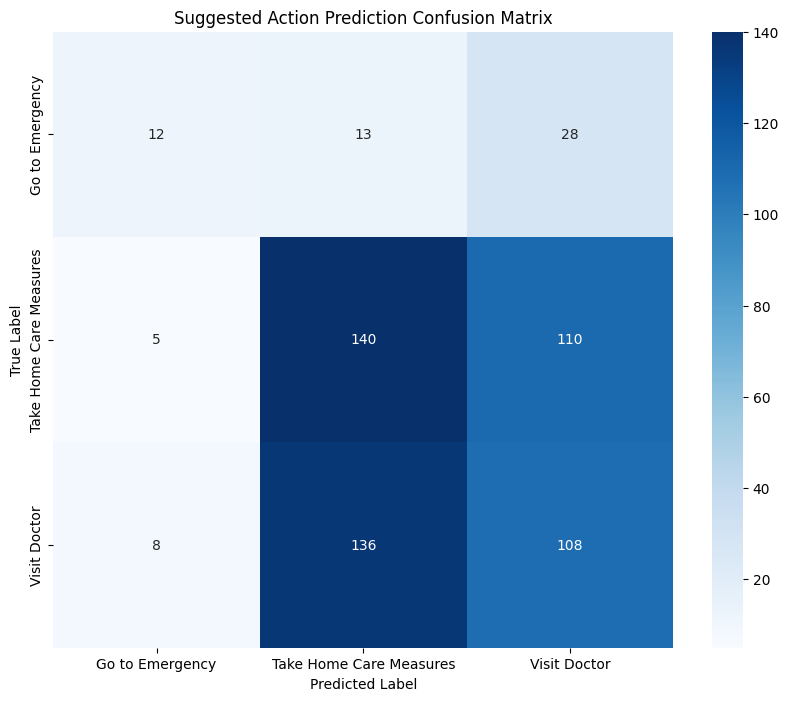

In [47]:
# Plot action model confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(action_true, action_preds),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder_action.classes_,
    yticklabels=label_encoder_action.classes_
)
plt.title('Suggested Action Prediction Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [48]:
# Evaluate condition prediction model
predicted_conditions = trainer_condition.predict(datasets_condition['validation'])
condition_preds = np.argmax(predicted_conditions.predictions, axis=1)
condition_true = predicted_conditions.label_ids


100%|██████████| 140/140 [00:03<00:00, 46.37it/s]


In [49]:
# Calculate and print condition model metrics
print("\n#---- Potential Condition Prediction Model Performance ----#")
print(f"Accuracy: {accuracy_score(condition_true, condition_preds)*100:.2f}%\n")
print("Classification Report:")
print(classification_report(
    condition_true, 
    condition_preds,
    target_names=label_encoder_condition.classes_
))


#---- Potential Condition Prediction Model Performance ----#
Accuracy: 76.25%

Classification Report:
                   precision    recall  f1-score   support

Allergic Reaction       0.00      0.00      0.00         9
          Anxiety       0.67      0.86      0.75        56
        Arthritis       0.93      0.90      0.92        92
           Asthma       0.69      0.82      0.75        45
      Common Cold       1.00      0.88      0.94        50
         Covid-19       0.00      0.00      0.00        13
      Dehydration       1.00      1.00      1.00        38
         Diabetes       0.00      0.00      0.00         5
              Flu       0.81      0.84      0.83        51
   Food Poisoning       1.00      0.93      0.97        45
  Gastroenteritis       0.00      0.00      0.00         6
     Hypertension       0.00      0.00      0.00         8
    Kidney Stones       0.00      0.00      0.00         9
         Migraine       0.67      0.79      0.73        52
    Muscle 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

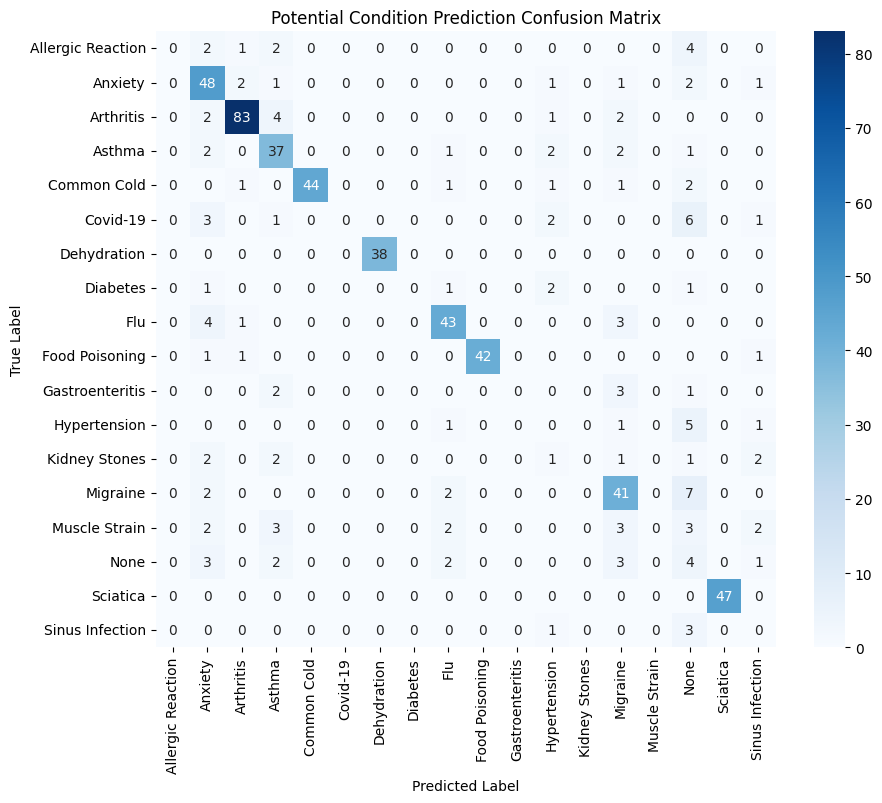

In [50]:
# Plot condition model confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(condition_true, condition_preds),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder_condition.classes_,
    yticklabels=label_encoder_condition.classes_
)
plt.title('Potential Condition Prediction Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Export

In [51]:
# Add this code to your notebook after training
import pickle

# Save 'label_encoder_action'
with open('label_encoder_action.pkl', 'wb') as f:
    pickle.dump(label_encoder_action, f)

# Save 'label_encoder_condition'
with open('label_encoder_condition.pkl', 'wb') as f:
    pickle.dump(label_encoder_condition, f)